In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/xhding/workspaces/torch-deep-retina')
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import h5py
from  torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from scipy.stats import pearsonr
from fnn.evaluation import *
from fnn.utils import select_model
from fnn.config import get_custom_cfg
from fnn.data import TestDataset, ValidationDataset
from fnn.notebook.utils import *
from torchdeepretina.datas import loadexpt

In [3]:
device = torch.device('cuda:0')
cfg = get_custom_cfg('bn_cnn_stack')
model = select_model(cfg, device)
checkpoint_path = '/home/xhding/saved_model/BN_CNN_Stack/epoch_045_loss_-3.54_pearson_0.6417.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

BN_CNN_Stack(
  (bipolar): Sequential(
    (0): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Sequential(
        (0): Conv2d(40, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (5): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (6): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    (1): Flatten()
    (2): BatchNorm1d(10368, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    (3): GaussianNoise(std=0.05, trainable=False, adapt=False, momentum=0.95)
    (4): ReLU()
  )
  (amacrine): Sequential(
    (0): Reshape(shape=(-1, 8, 36, 36))
    (1): LinearStackedConv2d(
      bias=True, abs_bnorm=False
      (convs): Seq

In [4]:
with h5py.File('/home/TRAIN_DATA/15-10-07/naturalscene.h5', 'r') as f:
    target = f['test']['response']['firing_rate_10ms'][:5, 40:]
    single_trial = []
    for cell in ['cell01', 'cell02', 'cell03', 'cell04', 'cell05']:
        single_trial.append(f['test']['repeats'][cell])
    single_trial = np.stack(single_trial)
single_trial = np.swapaxes(single_trial,0,1)
single_trial = np.swapaxes(single_trial,1,2)[:,40:5996,:]
target = np.swapaxes(target,0,1)[:5956,:]

In [5]:
test_data = DataLoader(TestDataset(cfg), batch_size=512)
test_pc, _, pred, targ = pearsonr_batch_eval(model, test_data, 5, device, cfg)
test_pc

0.7327945653435284

In [6]:
noise = single_trial - single_trial.mean(0)

In [10]:
noise.mean(1)/np.abs(noise).mean(1)

array([[ 0.38407294, -0.0873194 , -0.34526325,  0.33191879,  0.34949552],
       [ 0.33203444, -0.02565715,  0.31659587,  0.31917611,  0.09716614],
       [ 0.0175868 ,  0.1921134 , -0.02437577,  0.03155318, -0.13690518],
       [-0.16191751, -0.02726209, -0.05680153, -0.3056858 , -0.16409049],
       [-0.4998475 , -0.05056264,  0.04057811, -0.39026299, -0.14570198]])

In [12]:
pred_noise = pred_single_trial - pred_single_trial.mean(0)

In [13]:
pred_noise.mean(1)/np.abs(pred_noise).mean(1)

array([[-0.04408789, -0.04901244, -0.04909724, -0.03607963, -0.04047619],
       [-0.00142268,  0.02257172,  0.03331314,  0.01751863, -0.01813317],
       [ 0.05968452,  0.0358297 , -0.01233046,  0.03969202,  0.02366687],
       [-0.02473392, -0.00073714,  0.        , -0.04059339,  0.01327701],
       [-0.01785204,  0.0021933 , -0.01231527, -0.03288331, -0.00174876],
       [-0.00297133, -0.03419176, -0.04181601,  0.0565635 ,  0.00120301],
       [-0.0166017 , -0.03369176,  0.00450315,  0.01659973, -0.02561811],
       [ 0.00998004,  0.0457811 ,  0.06443299, -0.03765348,  0.01141018],
       [-0.01334322, -0.0052356 ,  0.02905288,  0.00734794,  0.00117786],
       [ 0.04889272,  0.01328114, -0.02218279,  0.00658868,  0.0348055 ]],
      dtype=float32)

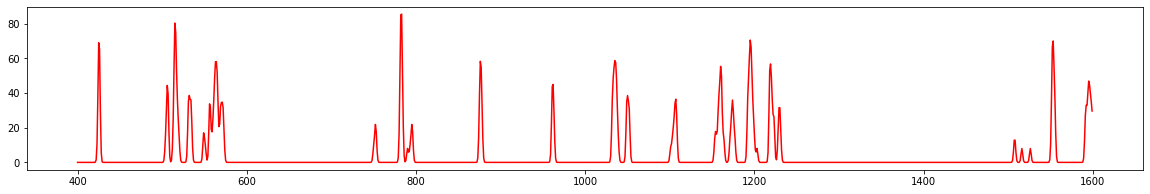

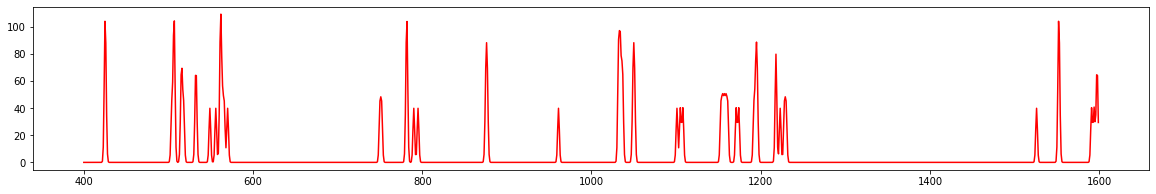

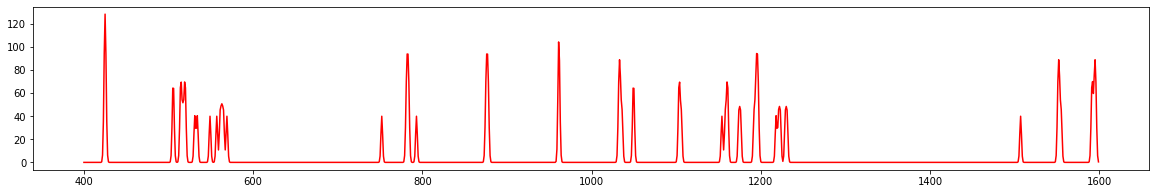

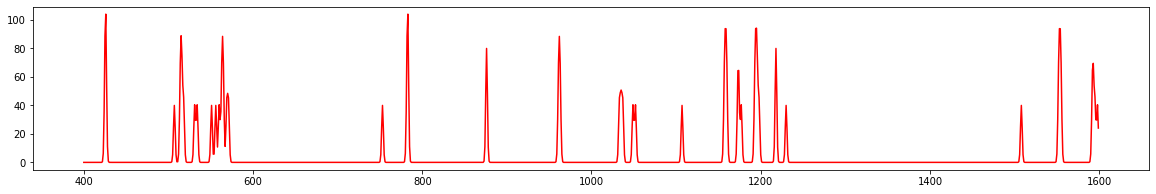

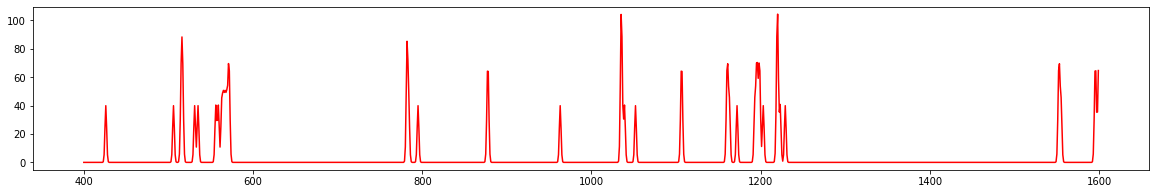

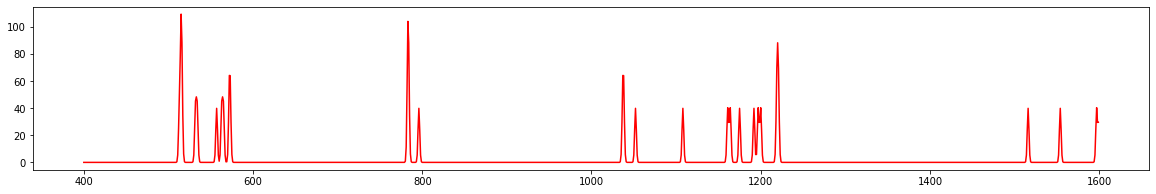

In [57]:
start = 400
end = 1600
cell = 0
plt.figure(figsize=(20,3))
plt.plot(np.arange(start, end), single_trial.mean(0)[start:end, cell], 'r')
plt.show()
for trial in range(5):
    plt.figure(figsize=(20,3))
    plt.plot(np.arange(start, end), single_trial[trial, start:end, cell], 'r')
    plt.show()

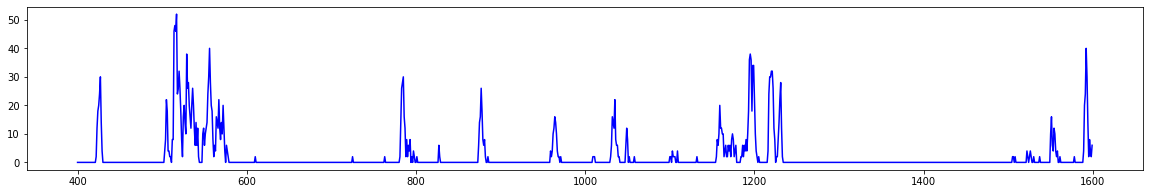

In [69]:
noiseless_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.1], gaussian=[0, 0, 0, 0])
start = 400
end = 1600
cell = 0
plt.figure(figsize=(20,3))
plt.plot(np.arange(start, end), noiseless_single_trial.mean(0)[start:end, cell], 'b')
plt.show()

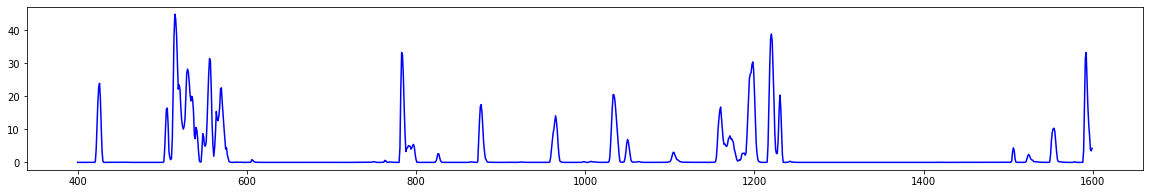

In [68]:
noiseless_single_trial = model_single_trial(model, test_data, device, n_repeats=1, poisson=[None, None, None], gaussian=[0, 0, 0, 0])
start = 400
end = 1600
cell = 0
plt.figure(figsize=(20,3))
plt.plot(np.arange(start, end), noiseless_single_trial[0, start:end, cell], 'b')
plt.show()

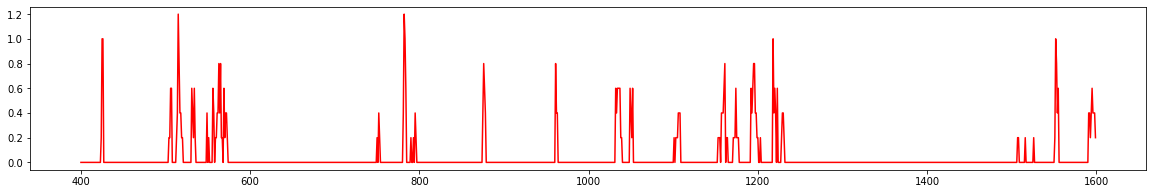

In [67]:
start = 400
end = 1600
cell = 0
plt.figure(figsize=(20,3))
plt.plot(np.arange(start, end), target_binned[start:end, cell], 'r')
plt.show()

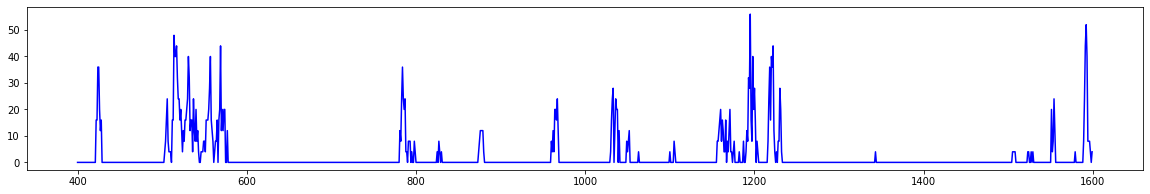

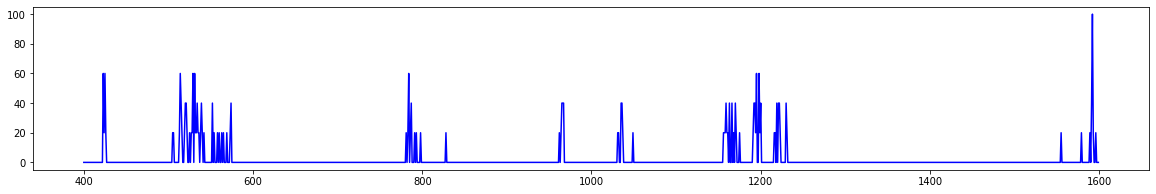

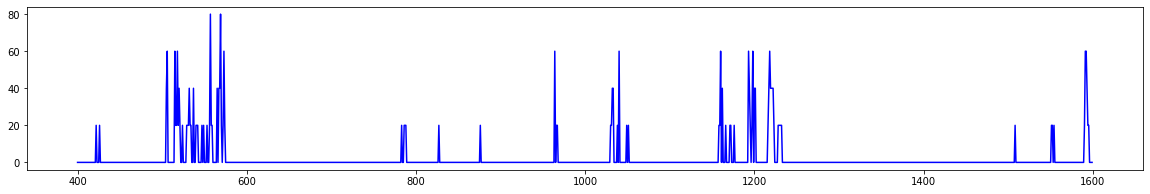

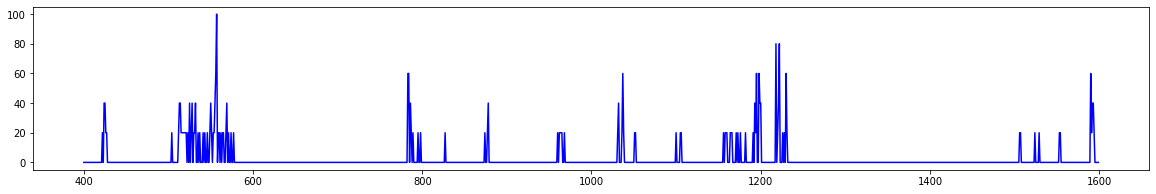

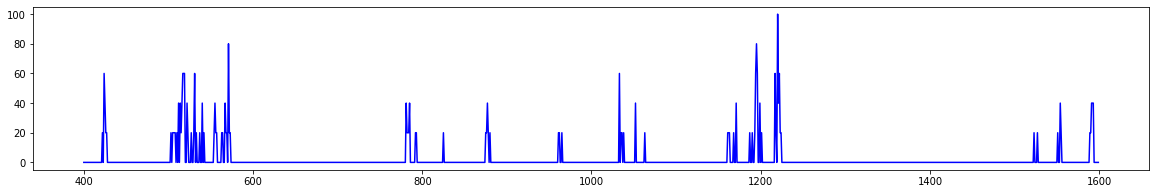

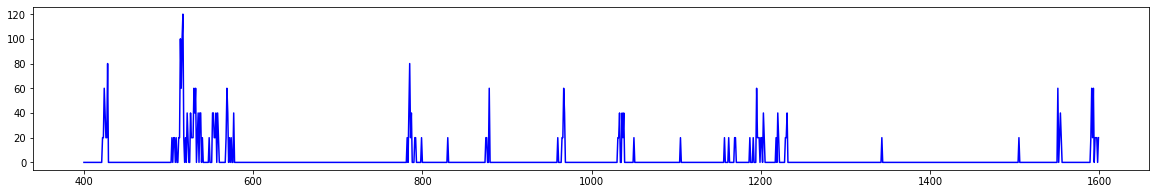

In [72]:
pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.05], gaussian=[0, 0, 0, 0])
start = 400
end = 1600
cell = 0
plt.figure(figsize=(20,3))
plt.plot(np.arange(start, end), pred_single_trial[:5].mean(0)[start:end, cell], 'b')
plt.show()
for trial in range(5):
    plt.figure(figsize=(20,3))
    plt.plot(np.arange(start, end), pred_single_trial[trial, start:end, cell], 'b')
    plt.show()

In [64]:
f = h5py.File('/home/TRAIN_DATA/15-10-07/naturalscene.h5', 'r')
target_binned = f['test']['response']['binned'][:5, 40:]
target_binned = np.swapaxes(target_binned,0,1)[:5956,:]

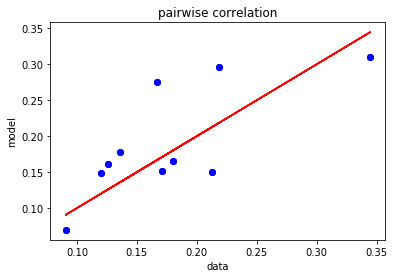

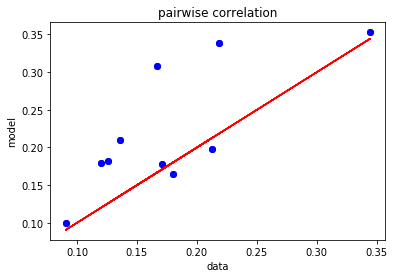

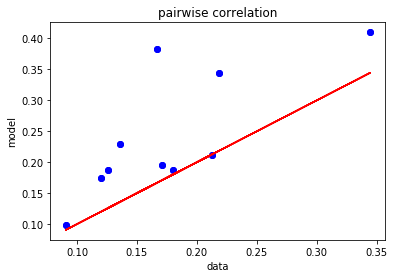

In [157]:
thre = 12
for k3 in [0.1, 0.2, 0.3]:
    pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, k3], gaussian=[0, 0, 0, 0], thre=thre)
    pred_corr = single_trial_corr_matrix(5, 5, pred_single_trial)
    corr  = single_trial_corr_matrix(5, 5, single_trial)
    diagonal_idxs = list(range(0, 25, 6))
    corr = np.delete(corr.flatten(), diagonal_idxs)
    pred_corr = np.delete(pred_corr.flatten(), diagonal_idxs)
    plt.plot(corr, pred_corr, 'bo')
    plt.plot(corr, corr, 'r-')
    plt.xlabel('data')
    plt.ylabel('model')
    plt.title('pairwise correlation')
    plt.show()

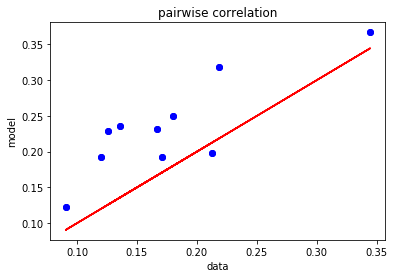

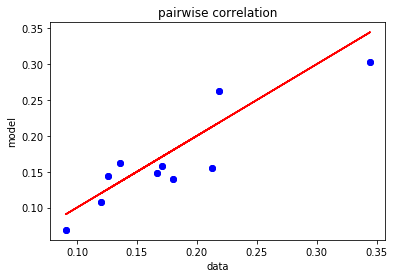

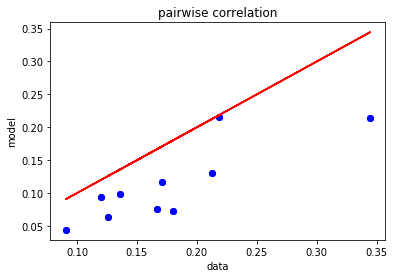

In [158]:
for thre in [10,20,30]:
    pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.1], gaussian=[0, 0, 0, 0])
    pred_single_trial[pred_single_trial < thre] = 0
    pred_corr = single_trial_corr_matrix(5, 5, pred_single_trial)
    corr  = single_trial_corr_matrix(5, 5, single_trial)
    diagonal_idxs = list(range(0, 25, 6))
    corr = np.delete(corr.flatten(), diagonal_idxs)
    pred_corr = np.delete(pred_corr.flatten(), diagonal_idxs)
    plt.plot(corr, pred_corr, 'bo')
    plt.plot(corr, corr, 'r-')
    plt.xlabel('data')
    plt.ylabel('model')
    plt.title('pairwise correlation')
    plt.show()

In [75]:
single_trial.shape

(5, 5956, 5)

In [76]:
scale_factor = single_trial.mean(axis=1)/single_trial.mean(axis=(0,1))
norm_single_trial = single_trial / np.expand_dims(scale_factor, 1)

In [80]:
norm_noise = norm_single_trial - norm_single_trial.mean(0)

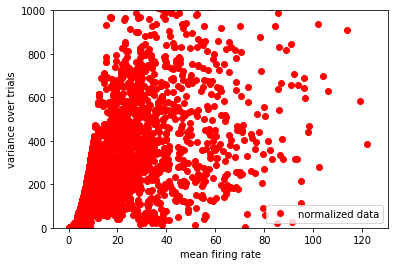

In [82]:
plt.plot(norm_single_trial.mean(0).flatten(), norm_noise.var(0).flatten(), 'ro', label='normalized data')
plt.ylim(0, 1000)
plt.xlabel('mean firing rate')
plt.ylabel('variance over trials')
plt.legend()
plt.show()

In [83]:
Fano(norm_single_trial)

0.09188305371152375

In [84]:
Fano2(norm_single_trial)

4.0914693133064536e-30

In [88]:
corr_matrix(5, norm_single_trial.mean(0))

array([[1.        , 0.200547  , 0.5171017 , 0.29824368, 0.22291225],
       [0.200547  , 1.        , 0.29732683, 0.27627309, 0.14222645],
       [0.5171017 , 0.29732683, 1.        , 0.23846959, 0.19849368],
       [0.29824368, 0.27627309, 0.23846959, 1.        , 0.28570608],
       [0.22291225, 0.14222645, 0.19849368, 0.28570608, 1.        ]])

In [6]:
mean_corr = corr_matrix(5, single_trial.mean(0))

In [152]:
for thre in [8, 10, 12]:
    for k3 in [0.05, 0.1, 0.2]:
        pred_single_trial = model_single_trial(model, test_data, device, n_repeats=10, poisson=[None, None, k3], gaussian=[0, 0, 0, 0], thre=thre)
        pred_mean_corr = corr_matrix(5, pred_single_trial.mean(0))
        error = (pred_mean_corr - mean_corr).mean()
        print(error, thre, k3)

0.01707262471039063 8 0.05
0.03192074645329085 8 0.1
0.03678291040730084 8 0.2
0.004911165798773585 10 0.05
0.014644966087359967 10 0.1
0.01749096241569652 10 0.2
-0.01196785584677766 12 0.05
-0.00010472447496147286 12 0.1
0.001573021314845806 12 0.2


In [151]:
for thre in [8, 10, 12, 14, 16]:
    pred_single_trial = model_single_trial(model, test_data, device, n_repeats=1, poisson=[None, None, None], gaussian=[0, 0, 0, 0], thre=thre)
    pred_mean_corr = corr_matrix(5, pred_single_trial.mean(0))
    error = (pred_mean_corr - mean_corr).mean()
    print(error, thre)

0.04313617262378717 8
0.024426053514303506 10
0.006836887483820409 12
-0.021161054413187635 14
-0.06417039144673044 16


In [153]:
k3 = 0.25
thre = 12
for std2 in [0.1, 0.15, 0.2, 0.25, 0.3]:
    pred_single_trial = model_single_trial(model, test_data, device, n_repeats=10, poisson=[None, None, k3], gaussian=[0, 0, std2, 0], thre=thre)
    stim_corr = stimuli_corr_matrix(5, 10, pred_single_trial)
    print(std2, stim_corr.mean())

0.1 0.3338379481225149
0.15 0.3188807804599216
0.2 0.29761821494595725
0.25 0.2707627759536307
0.3 0.23297330360525145


In [154]:
thre = 12
for k3 in [0.1, 0.2, 0.3]:
    for std2 in [0.1, 0.2, 0.3]:
        
        pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, k3], gaussian=[0, 0, std2, 0], thre=thre)
        pred_corr = single_trial_corr_matrix(5, 5, pred_single_trial)
        pred_stim_corr = stimuli_corr_matrix(5, 5, pred_single_trial)
        pred_noise_corr = pred_corr - pred_stim_corr
        
        corr = single_trial_corr_matrix(5, 5, single_trial)
        stim_corr = stimuli_corr_matrix(5, 5, single_trial)
        noise_corr = corr - stim_corr
        
        fano = Fano(pred_single_trial)
        
        print(k3, std2, (pred_corr - corr).mean(), (pred_noise_corr - noise_corr).mean(), (fano-0.09188))

0.1 0.1 0.0070581264194140994 -0.03367158710594348
0.1 0.2 -0.010526582851600672 -0.01754051406766677
0.1 0.3 -0.03865454577662635 0.014422639788755028
0.2 0.1 0.028051160185177042 -0.05266150206066842
0.2 0.2 0.02317483620697613 -0.03117952986963394
0.2 0.3 -0.006715116171490659 0.004842344986592424
0.3 0.1 0.038652232300275764 -0.06395364144967956
0.3 0.2 0.026963088413504237 -0.04131366011393314
0.3 0.3 0.0011116782673368786 -0.009623200940350187


In [7]:
thre = 14
diagonal_idxs = list(range(0, 25, 6))
for k3 in np.arange(0.15, 0.37, 0.02):
    for std2 in np.arange(0.15, 0.37, 0.02):
        
        pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, k3], gaussian=[0, 0, std2, 0], thre=thre)
        pred_corr = single_trial_corr_matrix(5, 5, pred_single_trial)
        pred_stim_corr = stimuli_corr_matrix(5, 5, pred_single_trial)
        pred_noise_corr = pred_corr - pred_stim_corr
        pred_corr = np.delete(pred_corr.flatten(), diagonal_idxs)
        pred_noise_corr = np.delete(pred_noise_corr.flatten(), diagonal_idxs)
        
        corr = single_trial_corr_matrix(5, 5, single_trial)
        stim_corr = stimuli_corr_matrix(5, 5, single_trial)
        noise_corr = corr - stim_corr
        corr = np.delete(corr.flatten(), diagonal_idxs)
        noise_corr = np.delete(noise_corr.flatten(), diagonal_idxs)
        
        fano = Fano(pred_single_trial)
        
        error_corr = np.abs(pred_corr - corr).sum() / corr.sum()
        error_noise = np.abs((pred_noise_corr - noise_corr).sum()) / np.abs(noise_corr).sum()
        error_fano = np.abs(fano - 0.09188) / 0.09188
        error = error_corr + error_noise + error_fano
        
        print(k3, std2, error_corr, error_noise, error_fano, error)

0.15 0.15 0.20367136399622235 0.8569685829944961 0.015200047919581062 1.0758399949102995
0.15 0.16999999999999998 0.19167148653599206 0.7638895970455288 0.08211233556711726 1.037673419148638
0.15 0.18999999999999997 0.20691954200757395 0.699303478424455 0.10888341989110328 1.0151064403231322
0.15 0.20999999999999996 0.20227071649474868 0.310883763408445 0.1756316372296786 0.6887861171328722
0.15 0.22999999999999995 0.25940314127108244 0.716155379598793 0.2090235857741439 1.1845821066440194
0.15 0.24999999999999994 0.1966724350261764 0.850501675132696 0.2904204489824613 1.3375945591413338
0.15 0.2699999999999999 0.16248368529959764 0.5377270731384135 0.3490489282242671 1.0492596866622783
0.15 0.2899999999999999 0.15285508589655644 0.6774783014661351 0.4019725397456247 1.232305927108316
0.15 0.30999999999999994 0.23766832321303163 0.7112052336227747 0.4444267394286318 1.393300296264438
0.15 0.3299999999999999 0.2364970856682026 0.5303814560491877 0.4918420462178623 1.2587205879352528
0.1

In [11]:
for thre in [14, 15, 16, 17]:
    pred_single_trial = model_single_trial(model, test_data, device, n_repeats=10, poisson=[None, None, 0.21], gaussian=[0, 0, 0.27, 0], thre=thre)
    pred_mean_corr = corr_matrix(5, pred_single_trial.mean(0))
    error = (pred_mean_corr - mean_corr).mean()
    print(error, thre)

-0.0008291712828336295 14
0.008189792134948247 15
-0.01786219262018531 16
-0.033607318586487696 17


In [182]:
for thre in [10, 11, 12, 13]:
    pred_single_trial = model_single_trial(model, test_data, device, n_repeats=1, poisson=[None, None, None], gaussian=[0, 0, 0, 0], thre=thre)
    pred_mean_corr = corr_matrix(5, pred_single_trial.mean(0))
    error = (pred_mean_corr - mean_corr).mean()
    print(error, thre)

0.024426053514303506 10
0.013646387798188586 11
0.006836887483820409 12
-0.003828901639625959 13


In [167]:
pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.35], gaussian=[0, 0, 0.25, 0], thre=12)
Fano(pred_single_trial)

0.09281232

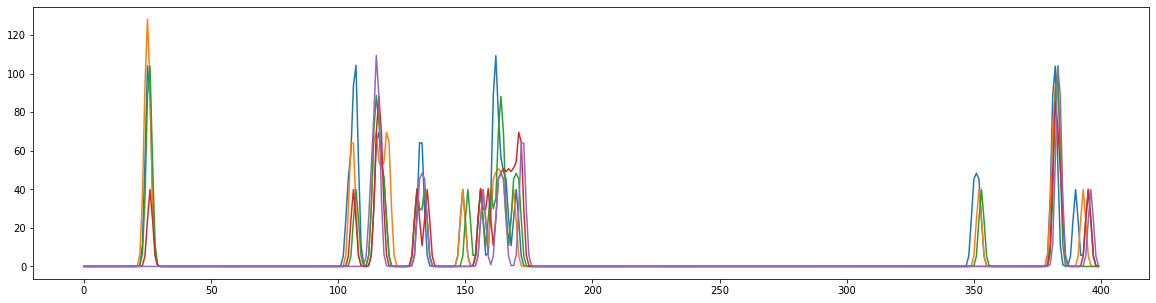

In [128]:
plt.figure(figsize=(20,5))
for i in range(5):
    plt.plot(single_trial[i,400:800,0])

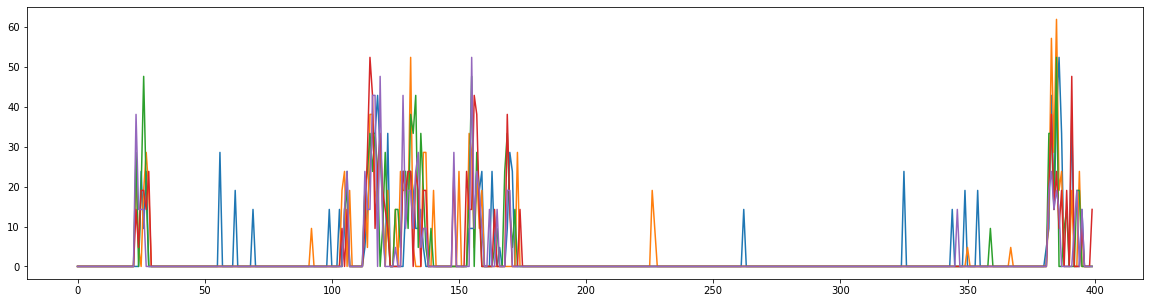

In [18]:
pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.21], gaussian=[0, 0, 0.27, 0], thre=12)
plt.figure(figsize=(20,5))
for i in range(5):
    plt.plot(pred_single_trial[i,400:800,0])

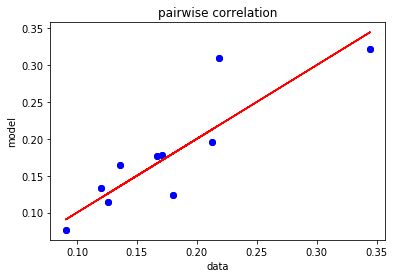

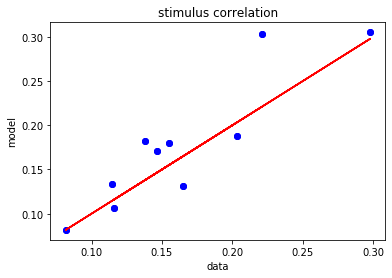

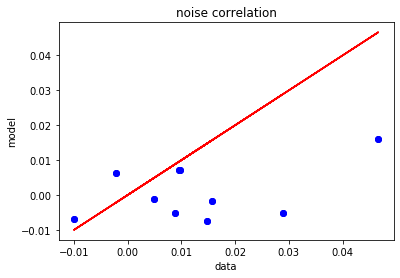

In [8]:
pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.35], gaussian=[0, 0, 0.25, 0], thre=14)
correlation_plot(single_trial, pred_single_trial, 5, 5)

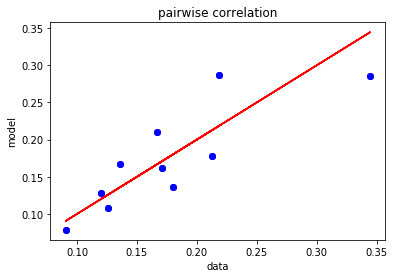

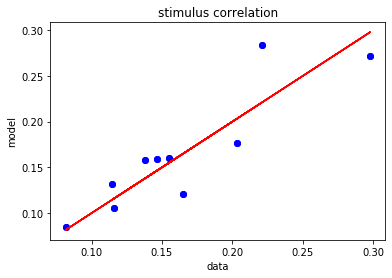

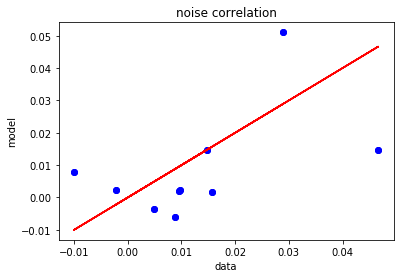

In [17]:
pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.21], gaussian=[0, 0, 0.27, 0], thre=14)
correlation_plot(single_trial, pred_single_trial, 5, 5)

In [21]:
thre = 14
diagonal_idxs = list(range(0, 25, 6))
for k3 in [0.15, 0.2, 0.25, 0.3, 0.35, 0.4]:
    for std0 in [0.45, 0.5, 0.55, 0.6]:
        
        pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, k3], gaussian=[std0, 0, 0, 0], thre=thre)
        pred_corr = single_trial_corr_matrix(5, 5, pred_single_trial)
        pred_stim_corr = stimuli_corr_matrix(5, 5, pred_single_trial)
        pred_noise_corr = pred_corr - pred_stim_corr
        pred_corr = np.delete(pred_corr.flatten(), diagonal_idxs)
        pred_noise_corr = np.delete(pred_noise_corr.flatten(), diagonal_idxs)
        
        corr = single_trial_corr_matrix(5, 5, single_trial)
        stim_corr = stimuli_corr_matrix(5, 5, single_trial)
        noise_corr = corr - stim_corr
        corr = np.delete(corr.flatten(), diagonal_idxs)
        noise_corr = np.delete(noise_corr.flatten(), diagonal_idxs)
        
        fano = Fano(pred_single_trial)
        
        error_corr = np.abs(pred_corr - corr).sum() / corr.sum()
        error_noise = np.abs((pred_noise_corr - noise_corr).sum()) / np.abs(noise_corr).sum()
        error_fano = np.abs(fano - 0.09188) / 0.09188
        error = error_corr + error_noise + error_fano
        
        print(k3, std0, error_corr, error_noise, error_fano, error)

0.15 0.45 0.20791040789693208 0.9900786407585643 0.2571673271030148 1.4551563757585113
0.15 0.5 0.2511004584243546 0.9531915348880889 0.3269398898262535 1.5312318831386968
0.15 0.55 0.19246983944094354 0.7927139108041721 0.4056172262444203 1.390800976489536
0.15 0.6 0.20485409965007875 0.4935212126403526 0.47124363979568773 1.169618952086119
0.2 0.45 0.23871125300914814 0.7892894681851373 0.12458105042129167 1.152581771615577
0.2 0.5 0.23689269381279549 0.3355090963823088 0.22328891759859146 0.7956907077936958
0.2 0.55 0.21434045566114093 0.5628740758957097 0.3066788192256201 1.0838933507824708
0.2 0.6 0.20768612533150949 0.9147674287881938 0.37235769822797826 1.4948112523476818
0.25 0.45 0.22814664990881212 0.8740564319411297 0.0928717264674464 1.195074808317388
0.25 0.5 0.2461577212223469 0.6596294224757957 0.17526778486639608 1.0810549285645388
0.25 0.55 0.21416793409846901 0.5461613582350683 0.26817144865464476 1.0285007409881821
0.25 0.6 0.2177837405375085 0.7859272280834732 0.330

In [22]:
thre = 14
diagonal_idxs = list(range(0, 25, 6))
for k3 in [0.3, 0.4, 0.5, 0.6, 0.7]:
    for std0 in [0.4, 0.5, 0.6, 0.7, 0.8]:
        
        pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, k3], gaussian=[std0, 0, 0, 0], thre=thre)
        pred_corr = single_trial_corr_matrix(5, 5, pred_single_trial)
        pred_stim_corr = stimuli_corr_matrix(5, 5, pred_single_trial)
        pred_noise_corr = pred_corr - pred_stim_corr
        pred_corr = np.delete(pred_corr.flatten(), diagonal_idxs)
        pred_noise_corr = np.delete(pred_noise_corr.flatten(), diagonal_idxs)
        
        corr = single_trial_corr_matrix(5, 5, single_trial)
        stim_corr = stimuli_corr_matrix(5, 5, single_trial)
        noise_corr = corr - stim_corr
        corr = np.delete(corr.flatten(), diagonal_idxs)
        noise_corr = np.delete(noise_corr.flatten(), diagonal_idxs)
        
        fano = Fano(pred_single_trial)
        
        error_corr = np.abs(pred_corr - corr).sum() / corr.sum()
        error_noise = np.abs((pred_noise_corr - noise_corr).sum()) / np.abs(noise_corr).sum()
        error_fano = np.abs(fano - 0.09188) / 0.09188
        error = error_corr + error_noise + error_fano
        
        print(k3, std0, error_corr, error_noise, error_fano, error)

0.3 0.4 0.2511171893169468 0.7131922419261776 0.0367528065734186 1.001062237816543
0.3 0.5 0.20625613717085675 0.6520795336342275 0.1454764096748325 1.0038120804799169
0.3 0.6 0.21081530740995025 0.5057985022968879 0.32728865938597673 1.043902469092815
0.3 0.7 0.2073736616567546 0.46524110332517576 0.44658812139674686 1.1192028863786772
0.3 0.8 0.2413529800297755 0.35141097045017017 0.5588562398772682 1.1516201903572139
0.4 0.4 0.2560458970204835 0.8543313126530365 0.08963417002674184 1.2000113797002618
0.4 0.5 0.23409103235733442 0.7370688199041261 0.11304157043364857 1.084201422695109
0.4 0.6 0.20700541161687816 0.7304307571064147 0.28666734469679056 1.2241035134200833
0.4 0.7 0.2084333216253229 0.5199626896305534 0.4155190056907544 1.1439150169466306
0.4 0.8 0.23478532065631158 0.5293495716651362 0.5436942921444597 1.3078291844659073
0.5 0.4 0.2621934773366054 0.6380504707831129 0.08681173959295287 0.9870556877126713
0.5 0.5 0.22083124035138227 0.7656868230184412 0.08803493085507466

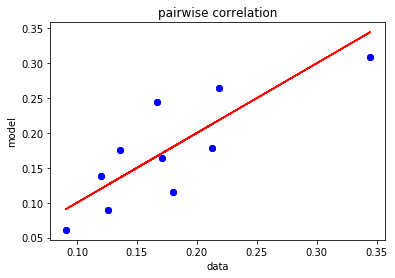

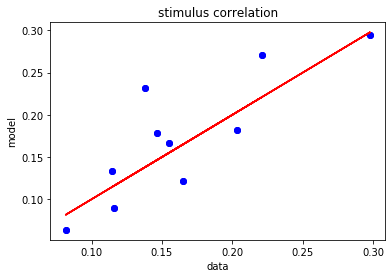

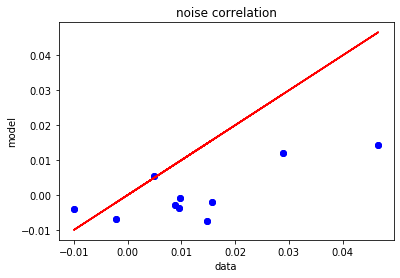

In [23]:
pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.2], gaussian=[0.5, 0, 0, 0], thre=14)
correlation_plot(single_trial, pred_single_trial, 5, 5)

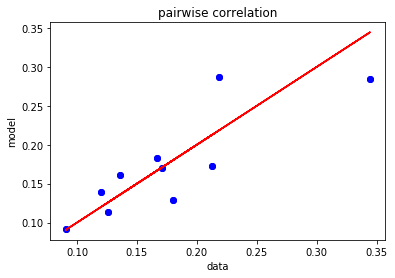

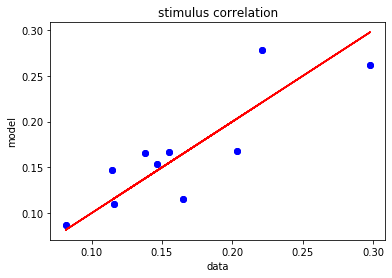

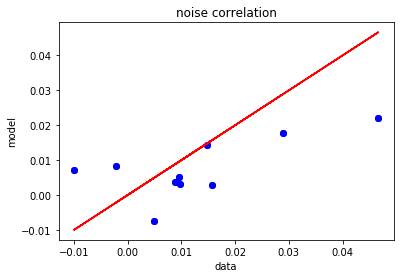

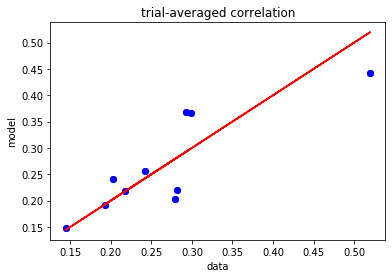

0.11203727


In [42]:
pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.4], gaussian=[0, 0, 0.3, 0], thre=14)
correlation_plot(single_trial, pred_single_trial, 5, 5)
print(Fano(pred_single_trial))

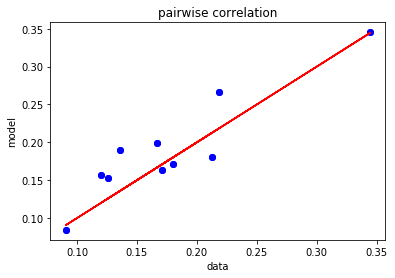

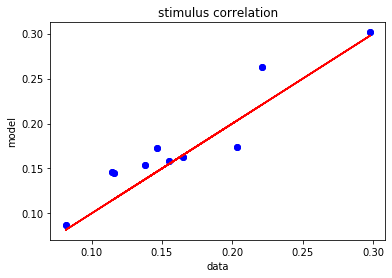

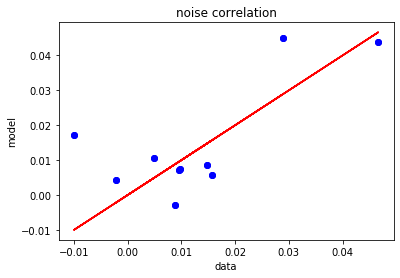

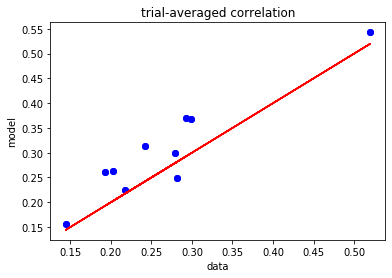

0.04576913


In [43]:
pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.4], gaussian=[0, 0, 0.3, 0], thre=0)
correlation_plot(single_trial, pred_single_trial, 5, 5)
print(Fano(pred_single_trial))

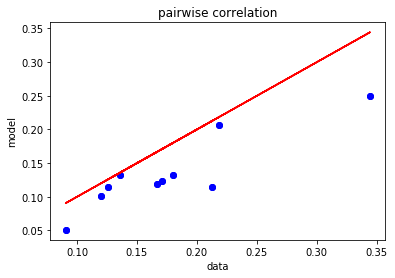

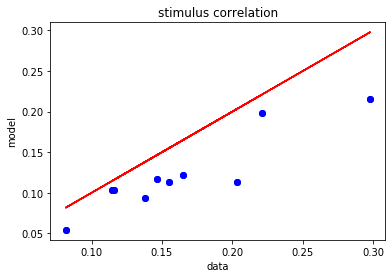

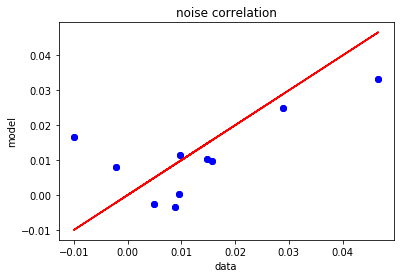

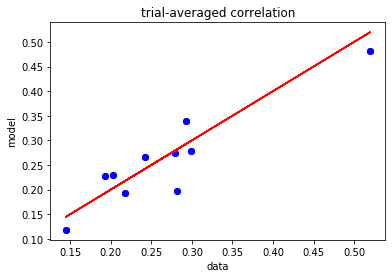

0.0859467


In [57]:
pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.13], gaussian=[0, 0, 0.3, 0], thre=0)
correlation_plot(single_trial, pred_single_trial, 5, 5)
print(Fano(pred_single_trial))

0.0 0.16871172068819387 0.5847656967659218 1.3402852e-16 0.24074506392767653 5.551115123125783e-18 0.9999999902089546
0.1 0.14641926701010827 0.5934691913170734 0.034781113 0.22754545898693976 0.0018229138549952812 0.8835411092706803
0.2 0.11662302615466369 0.5883457988573868 0.068435825 0.2163369756337897 0.0016205121575330196 0.8577251562141073
0.3 0.08189418187215017 0.5904242527042538 0.104957916 0.191517599785966 0.005313704583217883 1.054597678336567
0.4 0.1123984448711441 0.5583806483781713 0.12804995 0.11958856425183972 0.009683505753321183 1.4863079102969339
0.5 0.20712873691633493 0.5001040960247223 0.14191623 0.06974560581948568 0.01838555765375569 1.7630501409012667
0.6 0.25786325464448545 0.4280923220477506 0.15195613 0.04051862199022788 0.02597608887536883 1.91854064192523
0.7 0.2896616217697317 0.3667097880201278 0.16307995 0.02558311662924532 0.02735073086139229 1.980668514237001
0.8 0.2951286979122354 0.30606173499313133 0.17285517 0.01439607314108495 0.036206262409427

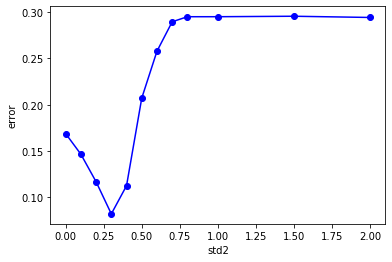

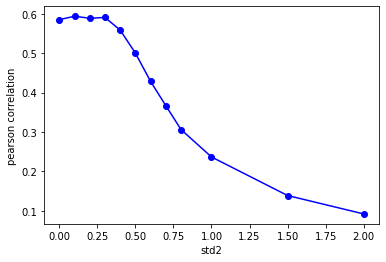

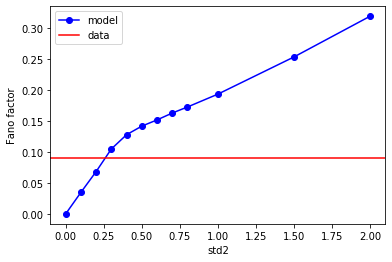

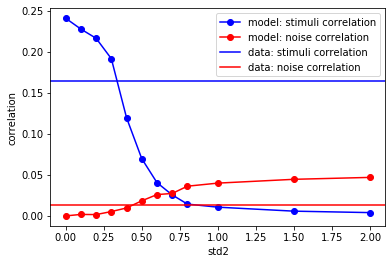

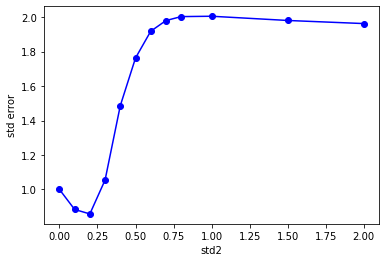

In [47]:
single_corr = single_trial_corr_matrix(5, 5, single_trial)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
std2_list = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.5, 2.0]
error_list = []
accuracy_list = []
fano_list = []
mean_stim_corr_list = []
mean_noise_corr_list = []
std_error_list = []
for std2 in std2_list:
    error, accuracy, fano, mean_stim_corr, mean_noise_corr, std_error = Noises(model, test_data, single_corr, single_trial, device, gaussian=[0, 0, std2, 0], thre=14)
    print(std2, error, accuracy, fano, mean_stim_corr, mean_noise_corr, std_error)
    error_list.append(error)
    accuracy_list.append(accuracy)
    fano_list.append(fano)
    mean_stim_corr_list.append(mean_stim_corr)
    mean_noise_corr_list.append(mean_noise_corr)
    std_error_list.append(std_error)
single_noise_plot('std2', std2_list, error_list, accuracy_list, fano_list, mean_stim_corr_list, mean_noise_corr_list, std_error_list)

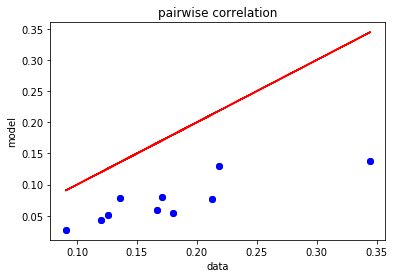

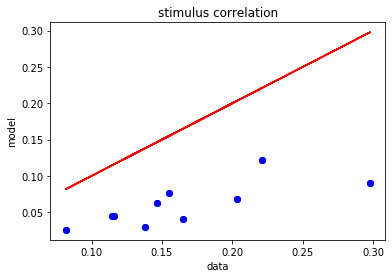

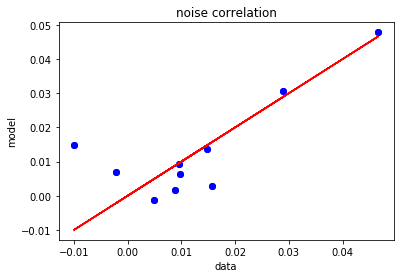

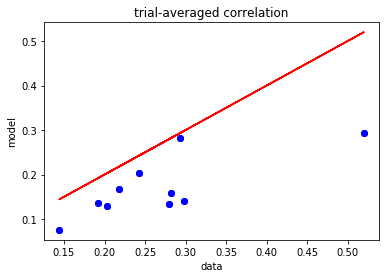

0.15333961


In [52]:
pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.2], gaussian=[0, 0, 0.5, 0], thre=14)
correlation_plot(single_trial, pred_single_trial, 5, 5)
print(Fano(pred_single_trial))

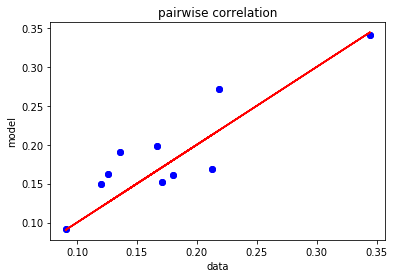

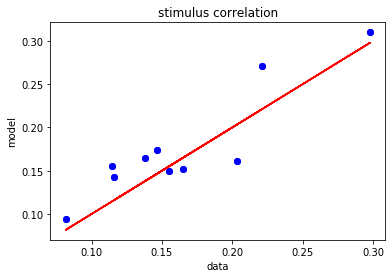

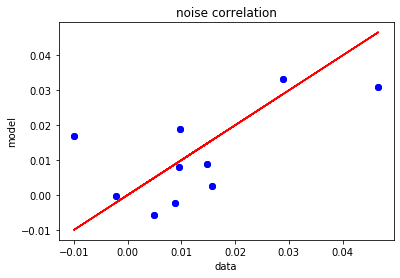

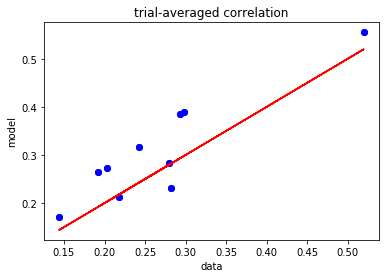

0.0685388


In [58]:
pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.33], gaussian=[0, 0, 0.3, 0], thre=5)
correlation_plot(single_trial, pred_single_trial, 5, 5)
print(Fano(pred_single_trial))

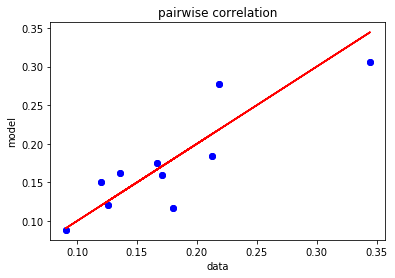

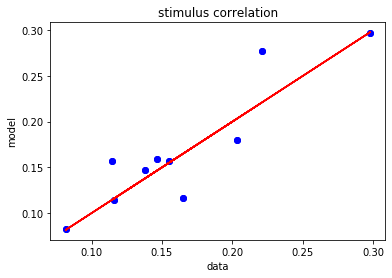

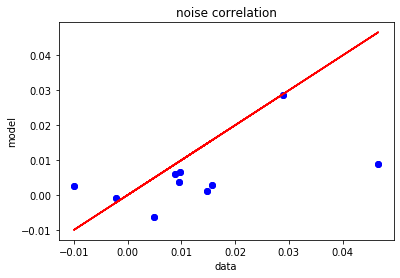

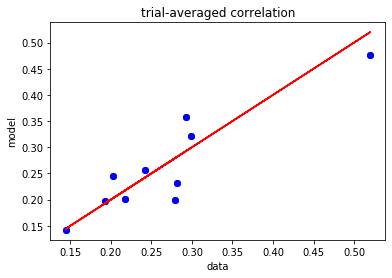

0.10367563


In [82]:
pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.44], gaussian=[0, 0, 0.29, 0], thre=13)
correlation_plot(single_trial, pred_single_trial, 5, 5)
print(Fano(pred_single_trial))

2.0 0.16871172068819387 0.5847656967659218 1.3402852e-16 0.24074506392767653 5.551115123125783e-18 0.9999999902089546
2.0 0.18182366337762265 0.5674248965003932 0.047269516 0.24891444961493464 0.002705058239240965 0.8604159713378273
2.0 0.2527921508911621 0.5087637255570666 0.08171857 0.2566087059551857 0.007248402594140582 0.9461499069183914
2.0 0.1962356520118467 0.44682856994147 0.11188115 0.20820524831231274 0.009517017711596399 1.3197759944477696
2.0 0.13242904325074437 0.38315960748485334 0.13265616 0.13616348492112737 0.00807510011325448 1.872382920428004
2.0 0.23681608138475208 0.3169053155486431 0.14182095 0.06275044792735533 0.012720127638467521 2.1502496014006915
2.0 0.2697395756877042 0.24604801314453942 0.15068263 0.03336439677462236 0.02806548901898583 2.2883180876135993
2.0 0.3081236339133159 0.19014719632805316 0.15808727 0.013214688566664357 0.031845772742856715 2.3118456150089153
2.0 0.31492512063933187 0.14685388389262038 0.1655756 0.009651345071497269 0.032508526032

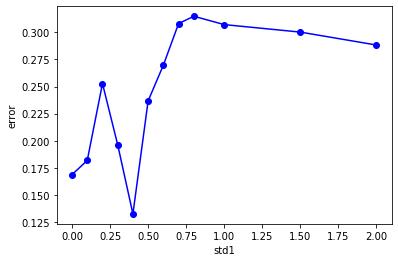

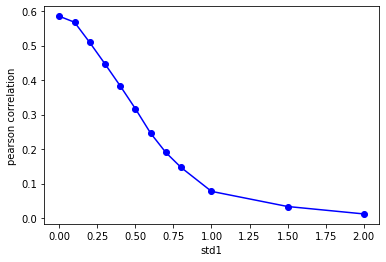

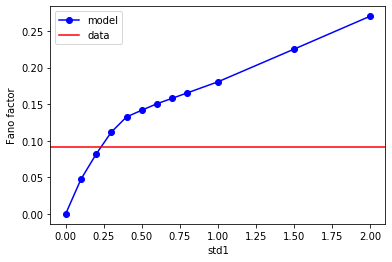

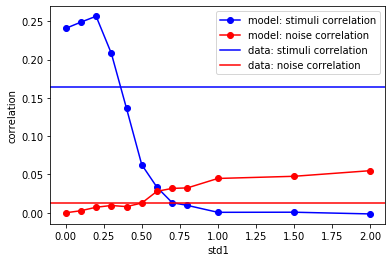

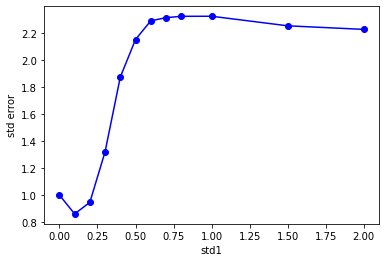

In [73]:
single_corr = single_trial_corr_matrix(5, 5, single_trial)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
std1_list = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.5, 2.0]
error_list = []
accuracy_list = []
fano_list = []
mean_stim_corr_list = []
mean_noise_corr_list = []
std_error_list = []
for std1 in std1_list:
    error, accuracy, fano, mean_stim_corr, mean_noise_corr, std_error = Noises(model, test_data, single_corr, single_trial, device, gaussian=[0, std1, 0, 0], thre=14)
    print(std2, error, accuracy, fano, mean_stim_corr, mean_noise_corr, std_error)
    error_list.append(error)
    accuracy_list.append(accuracy)
    fano_list.append(fano)
    mean_stim_corr_list.append(mean_stim_corr)
    mean_noise_corr_list.append(mean_noise_corr)
    std_error_list.append(std_error)
single_noise_plot('std1', std1_list, error_list, accuracy_list, fano_list, mean_stim_corr_list, mean_noise_corr_list, std_error_list)

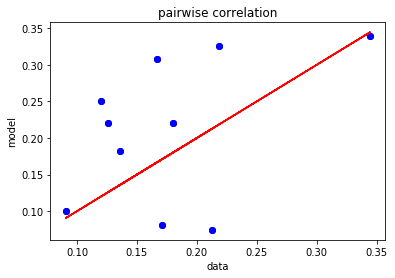

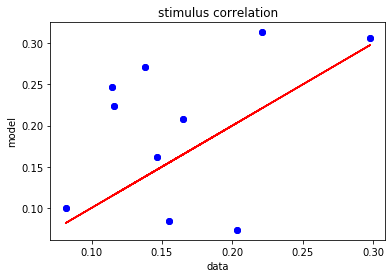

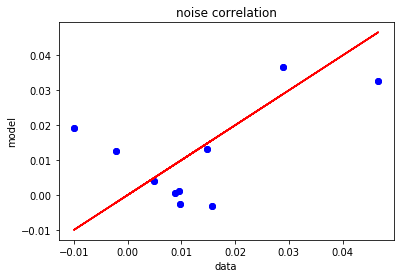

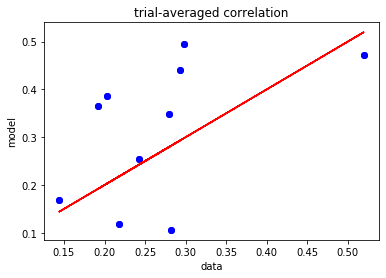

0.11901207


In [75]:
pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.4], gaussian=[0, 0.3, 0, 0], thre=14)
correlation_plot(single_trial, pred_single_trial, 5, 5)
print(Fano(pred_single_trial))

0.0 0.3791965492727798 0.692021847865742 9.780913e-17 0.3381778739844097 -8.326672684688674e-18 0.9999999903608846
0.1 0.3534693475769576 0.6933573630460593 0.022457773 0.32566874495855896 0.0015374000108708597 0.8845579724336098
0.2 0.26527913779954404 0.6913784762668158 0.048116423 0.28430994404390814 0.005286238719287082 0.9173964058734487
0.3 0.1179826958959895 0.6569346393984079 0.068970084 0.2120171407507109 0.010451026723196023 1.3245438873601967
0.4 0.07359298028892267 0.5909164731003287 0.08165829 0.12471699297962849 0.02227677050803272 1.6461489716172568
0.5 0.17119791332934514 0.5225273488685269 0.09399145 0.07678214380222505 0.026672227548129986 1.7963213861305567
0.6 0.22279289595952909 0.4485976089054313 0.10515281 0.046198788926115945 0.03525217238983499 1.8722814638145289
0.7 0.26750281429960837 0.36634721442678425 0.117498085 0.02618830808426551 0.0361954762371154 1.910558777524565
0.8 0.2694116054632964 0.330278791169998 0.12907113 0.020704843105835313 0.0408649102283

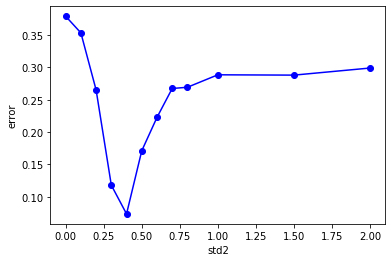

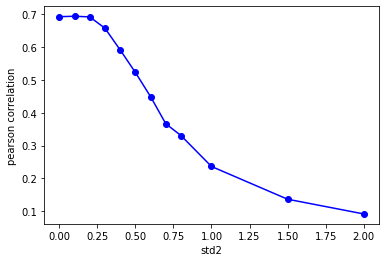

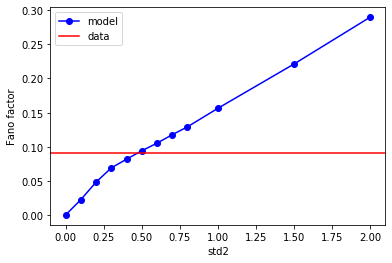

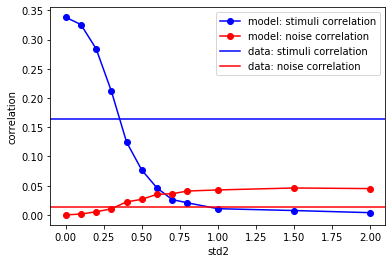

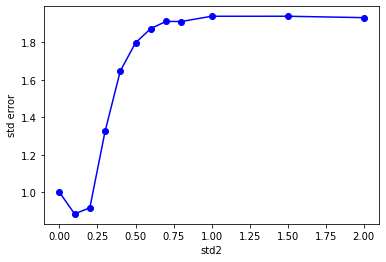

In [83]:
single_corr = single_trial_corr_matrix(5, 5, single_trial)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
std2_list = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.5, 2.0]
error_list = []
accuracy_list = []
fano_list = []
mean_stim_corr_list = []
mean_noise_corr_list = []
std_error_list = []
for std2 in std2_list:
    error, accuracy, fano, mean_stim_corr, mean_noise_corr, std_error = Noises(model, test_data, single_corr, single_trial, device, gaussian=[0, 0, std2, 0], thre=7)
    print(std2, error, accuracy, fano, mean_stim_corr, mean_noise_corr, std_error)
    error_list.append(error)
    accuracy_list.append(accuracy)
    fano_list.append(fano)
    mean_stim_corr_list.append(mean_stim_corr)
    mean_noise_corr_list.append(mean_noise_corr)
    std_error_list.append(std_error)
single_noise_plot('std2', std2_list, error_list, accuracy_list, fano_list, mean_stim_corr_list, mean_noise_corr_list, std_error_list)

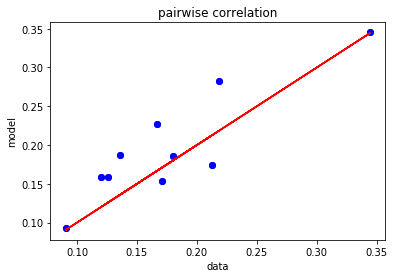

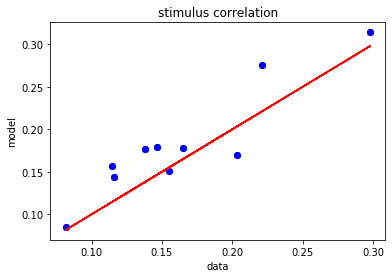

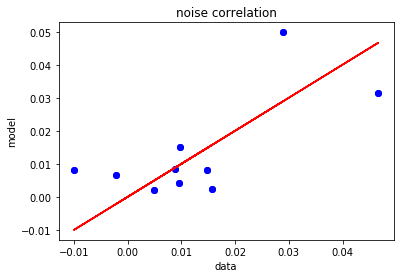

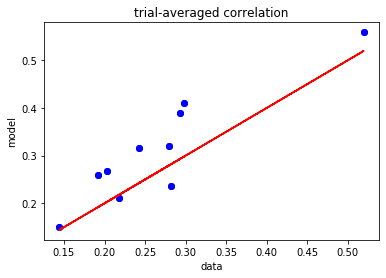

0.07709874


In [84]:
pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.4], gaussian=[0, 0, 0.3, 0], thre=7)
correlation_plot(single_trial, pred_single_trial, 5, 5)
print(Fano(pred_single_trial))

0.2 0.22131441795716303 0.6693752928806772 0.0545296 0.26749440934482616 0.0033523968622526613 0.8641499298117293
0.3 0.08950600268487575 0.6430514016443429 0.08038866 0.1990654631181472 0.00998585073328754 1.2131063413379262
0.4 0.08470495077808136 0.5864754206942016 0.09547935 0.12312561506872848 0.018314351824499142 1.6260091365612548
0.5 0.18405733978884667 0.5172300276543933 0.10748946 0.07026141086950159 0.027708876200337768 1.8126580847870208


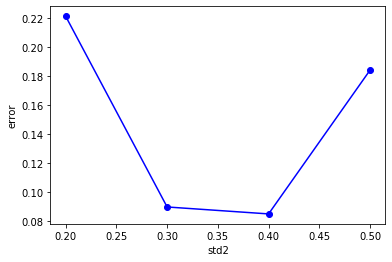

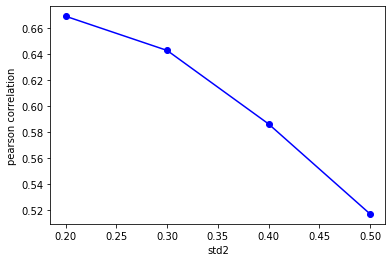

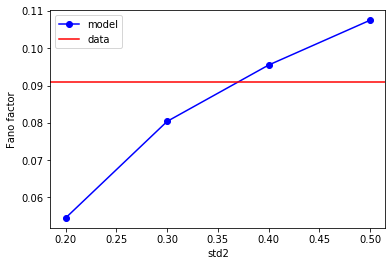

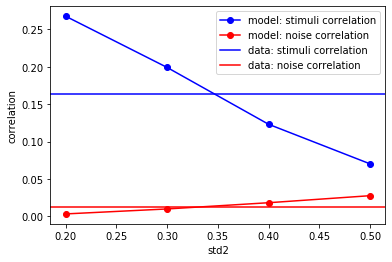

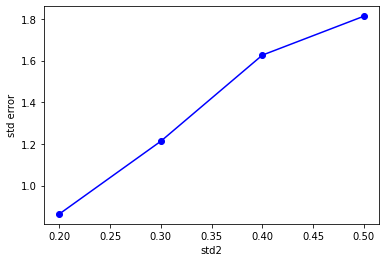

In [85]:
single_corr = single_trial_corr_matrix(5, 5, single_trial)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
std2_list = [0.2, 0.3, 0.4, 0.5]
error_list = []
accuracy_list = []
fano_list = []
mean_stim_corr_list = []
mean_noise_corr_list = []
std_error_list = []
for std2 in std2_list:
    error, accuracy, fano, mean_stim_corr, mean_noise_corr, std_error = Noises(model, test_data, single_corr, single_trial, device, gaussian=[0, 0, std2, 0], thre=9)
    print(std2, error, accuracy, fano, mean_stim_corr, mean_noise_corr, std_error)
    error_list.append(error)
    accuracy_list.append(accuracy)
    fano_list.append(fano)
    mean_stim_corr_list.append(mean_stim_corr)
    mean_noise_corr_list.append(mean_noise_corr)
    std_error_list.append(std_error)
single_noise_plot('std2', std2_list, error_list, accuracy_list, fano_list, mean_stim_corr_list, mean_noise_corr_list, std_error_list)

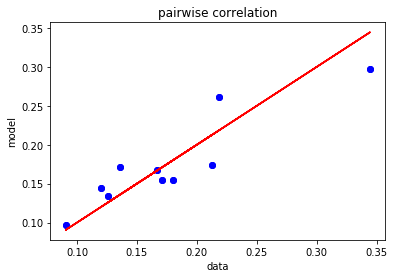

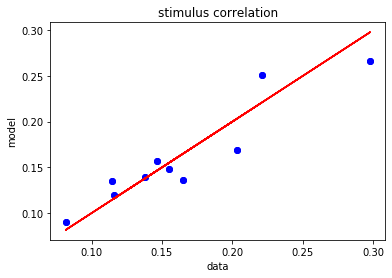

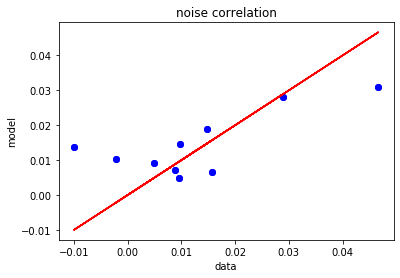

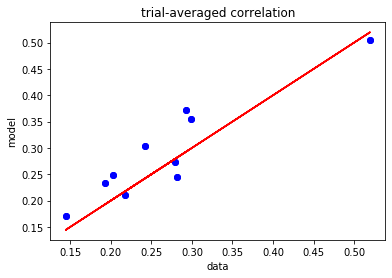

0.09069471


In [91]:
pred_single_trial = model_single_trial(model, test_data, device, n_repeats=5, poisson=[None, None, 0.6], gaussian=[0, 0, 0.34, 0], thre=9)
correlation_plot(single_trial, pred_single_trial, 5, 5)
print(Fano(pred_single_trial))